In [4]:
from __future__ import division, print_function
import sys, os, glob, gc, warnings
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
import matplotlib.pyplot as plt

from desitarget.targets import desi_mask

In [5]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [6]:
ls /global/cscratch1/sd/ziyaoz/dr9c/tractor

000/  005/  010/  015/  020/  025/  030/  035/  040/  045/  050/  154/  227/
001/  006/  011/  016/  021/  026/  031/  036/  041/  046/  051/  155/  266/
002/  007/  012/  017/  022/  027/  032/  037/  042/  047/  129/  187/  319/
003/  008/  013/  018/  023/  028/  033/  038/  043/  048/  130/  205/
004/  009/  014/  019/  024/  029/  034/  039/  044/  049/  143/  207/


In [7]:
tractor_dir = '027'
tractor_file_list = glob.glob('/global/cscratch1/sd/ziyaoz/dr9c/tractor/'+tractor_dir+'/*.fits')
tractor_file_list

# tractor_file_list = ['~dstn/legacypipe/py/dr9c2/tractor/010/tractor-0101m002.fits']

['/global/cscratch1/sd/ziyaoz/dr9c/tractor/027/tractor-0278p005.fits',
 '/global/cscratch1/sd/ziyaoz/dr9c/tractor/027/tractor-0273p010.fits',
 '/global/cscratch1/sd/ziyaoz/dr9c/tractor/027/tractor-0271m015.fits',
 '/global/cscratch1/sd/ziyaoz/dr9c/tractor/027/tractor-0278p010.fits',
 '/global/cscratch1/sd/ziyaoz/dr9c/tractor/027/tractor-0278p007.fits',
 '/global/cscratch1/sd/ziyaoz/dr9c/tractor/027/tractor-0273m002.fits',
 '/global/cscratch1/sd/ziyaoz/dr9c/tractor/027/tractor-0273p005.fits',
 '/global/cscratch1/sd/ziyaoz/dr9c/tractor/027/tractor-0276p005.fits',
 '/global/cscratch1/sd/ziyaoz/dr9c/tractor/027/tractor-0273p015.fits',
 '/global/cscratch1/sd/ziyaoz/dr9c/tractor/027/tractor-0273m005.fits',
 '/global/cscratch1/sd/ziyaoz/dr9c/tractor/027/tractor-0278p002.fits',
 '/global/cscratch1/sd/ziyaoz/dr9c/tractor/027/tractor-0276p000.fits',
 '/global/cscratch1/sd/ziyaoz/dr9c/tractor/027/tractor-0273m010.fits',
 '/global/cscratch1/sd/ziyaoz/dr9c/tractor/027/tractor-0276p002.fits',
 '/glo

In [38]:
# dr9c
cat_stack = []
for index in range(len(tractor_file_list)):
    cat = fitsio.read(tractor_file_list[index])
    cat = Table(cat)
    mask = cat['brick_primary']==True
    # print(len(cat), np.sum(mask))
    cat = cat[mask]
    cat_stack.append(cat)
cat_stack = vstack(cat_stack)
print(len(cat_stack))
cat = cat_stack

# dr8
cat_stack1 = []
for index in range(len(tractor_file_list)):
    cat1 = fitsio.read(os.path.join('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/tractor/', tractor_dir, os.path.basename(tractor_file_list[index])))
    cat1 = Table(cat1)
    mask = cat1['brick_primary']==True
    # print(len(cat1), np.sum(mask))
    cat1 = cat1[mask]
    cat_stack1.append(cat1)
cat_stack1 = vstack(cat_stack1)
print(len(cat_stack1))
cat1 = cat_stack1

350927
306441


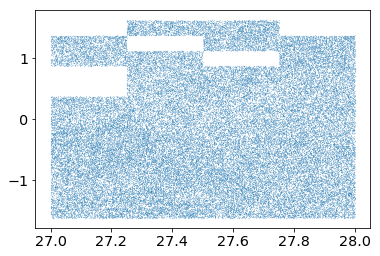

In [46]:
plt.plot(cat['ra'][::5], cat['dec'][::5], '.', ms=0.2);

In [39]:
# only look at PSF and REX objects
mask = (cat['type']=='PSF') | (cat['type']=='REX')
print(np.sum(mask)/len(mask))
cat = cat[mask]

mask = (cat1['type']=='PSF ') | (cat1['type']=='REX ')
print(np.sum(mask)/len(mask))
cat1 = cat1[mask]

0.85227981888
0.849044351115


In [40]:
bands = ['g', 'r', 'z']
for band in bands: 
    # residual flux per sq arcsec
    cat[band+'_sky'] = (cat['apflux_resid_'+band][:, -1]-cat['apflux_resid_'+band][:, -2]) / (np.pi*7**2-np.pi*5**2)
    # residual flux per sq arcsec
    cat1[band+'_sky'] = (cat1['apflux_resid_'+band][:, -1]-cat1['apflux_resid_'+band][:, -2]) / (np.pi*7**2-np.pi*5**2)

# mask_clean = np.ones(len(cat), dtype=bool)
mask_clean = cat['maskbits']==0
mask_clean1 = cat1['maskbits']==0

dr9c: median g-band sky residuals per sq arcsec: 0.00015
DR8: median g-band sky residuals per sq arcsec: -0.00142


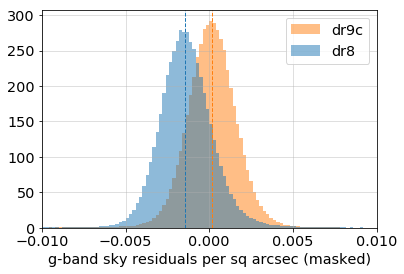

dr9c: median r-band sky residuals per sq arcsec: 0.00008
DR8: median r-band sky residuals per sq arcsec: -0.00148


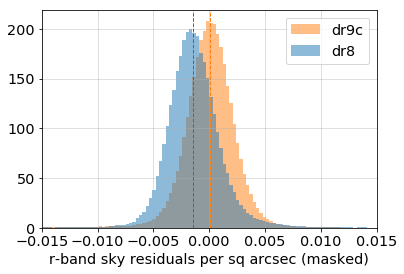

dr9c: median z-band sky residuals per sq arcsec: 0.00014
DR8: median z-band sky residuals per sq arcsec: -0.00193


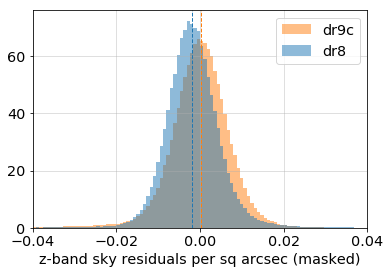

In [75]:
vranges = [0.01, 0.015, 0.04]

for band, vrange in zip(bands, vranges):

    tmp = cat[band+'_sky'][mask_clean]
    print('dr9c: median {}-band sky residuals per sq arcsec: {:.5f}'.format(band, np.median(tmp)))
    plt.hist(tmp, 100, range=(-vrange, vrange), density=True, alpha=0.5, label='dr9c', color='C1') 
    plt.axvline(np.median(tmp), color='C1', ls='--', lw=1)

    tmp = cat1[band+'_sky'][mask_clean1]
    print('DR8: median {}-band sky residuals per sq arcsec: {:.5f}'.format(band, np.median(tmp)))
    plt.hist(tmp, 100, range=(-vrange, vrange), density=True, alpha=0.5, label='dr8', color='C0')
    plt.axvline(np.median(tmp), color='C0', ls='--', lw=1)
    # correct for the offset
    cat1[band+'_sky_corr'] = cat1[band+'_sky'] - np.median(tmp)

    plt.xlim(-vrange, vrange)
    plt.grid(alpha=0.5)
    plt.xlabel(band+'-band sky residuals per sq arcsec (masked)')
    plt.legend()
    plt.show()

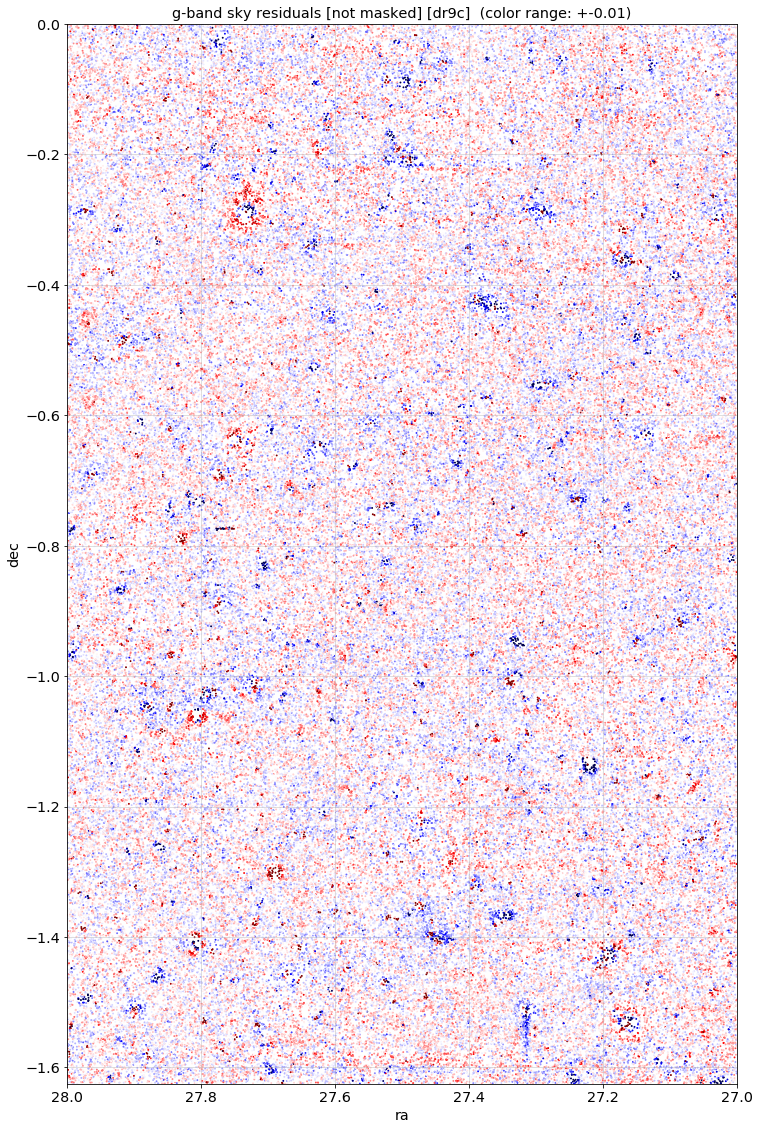

In [ ]:
ms, alpha = 0.8, 1.

# mask = np.ones(len(cat), dtype=bool)
# mask1 = np.ones(len(cat1), dtype=bool)
mask = cat['dec']<0
mask1 = cat1['dec']<0

# ramax, ramin, decmin, decmax = 28, 27, -1, 0
ramax, ramin, decmin, decmax = np.max(cat['ra'][mask]), np.min(cat['ra'][mask]),  np.min(cat['dec'][mask]), np.max(cat['dec'][mask])
xsize, ysize = 12, 12*((decmax-decmin)/(ramax-ramin)*np.cos((decmax+decmin)/2/180*np.pi))

for band, vrange in zip(bands, vranges):
 
    fig, ax = plt.subplots(figsize=(xsize, ysize))
    im = ax.scatter(cat['ra'][mask], cat['dec'][mask], c=cat[band+'_sky'][mask], vmin=-vrange, vmax=vrange, s=ms, alpha=alpha, cmap='seismic')
    ax.axis([ramax, ramin, decmin, decmax])
    ax.grid(alpha=0.5)
    ax.set_xlabel('ra')
    ax.set_ylabel('dec')
    # fig.colorbar(im)
    ax.set_title(band+'-band sky residuals [not masked] [dr9c]  (color range: +-{})'.format(vrange))
    plt.show()

    fig, ax = plt.subplots(figsize=(xsize, ysize))
    im = ax.scatter(cat1['ra'][mask1], cat1['dec'][mask1], c=cat1[band+'_sky_corr'][mask1], vmin=-vrange, vmax=vrange, s=ms, alpha=alpha, cmap='seismic')
    ax.axis([ramax, ramin, decmin, decmax])
    ax.grid(alpha=0.5)
    ax.set_xlabel('ra')
    ax.set_ylabel('dec')
    # fig.colorbar(im)
    ax.set_title(band+'-band offset-corrected sky residuals [not masked] [dr8]  (color range: +-{})'.format(vrange))
    plt.show()

--------

In [66]:
# sys.path.append(os.path.expanduser('~/git/Python/user_modules/'))
# import match_coord

# idx1, idx2, d2d, _, _ = match_coord.match_coord(cat['ra'], cat['dec'], cat1['ra'], cat1['dec'], search_radius=0.1)

# print(len(idx1)/len(cat))
# print(len(idx1)/len(cat1))

# ###############################################################

# print(np.median(cat['g_sky'][idx1]-cat1['g_sky'][idx2]))
# plt.hist(cat['g_sky'][idx1]-cat1['g_sky'][idx2], 100, range=(-0.01, 0.01))
# plt.grid(alpha=0.5)
# plt.show()

# x = (cat['flux_g'][idx1]-cat1['flux_g'][idx2])/cat1['flux_g'][idx2]
# print(np.median(x))
# plt.hist(x[np.isfinite(x)], 100, range=(-1., 1.))
# plt.grid(alpha=0.5)
# plt.show()

# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     cat['gmag'] = 22.5 - 2.5*np.log10(cat['flux_g'])
#     cat['rmag'] = 22.5 - 2.5*np.log10(cat['flux_r'])
#     cat['zmag'] = 22.5 - 2.5*np.log10(cat['flux_z'])
#     cat1['gmag'] = 22.5 - 2.5*np.log10(cat1['flux_g'])
#     cat1['rmag'] = 22.5 - 2.5*np.log10(cat1['flux_r'])
#     cat1['zmag'] = 22.5 - 2.5*np.log10(cat1['flux_z'])
    
# x = cat['gmag'][idx1]-cat1['gmag'][idx2]
# print(np.median(x[np.isfinite(x)]))
# plt.hist(x[np.isfinite(x)], 100, range=(-0.5, 0.5), normed=True)
# plt.xlabel('gmag_new - gmag_dr8')
# plt.grid(alpha=0.5)
# plt.show()